# 1.0 FIRE - Identifying flames

In [1]:
# import the necessary packages
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

I'll get this B12 band and manually crop the fire.

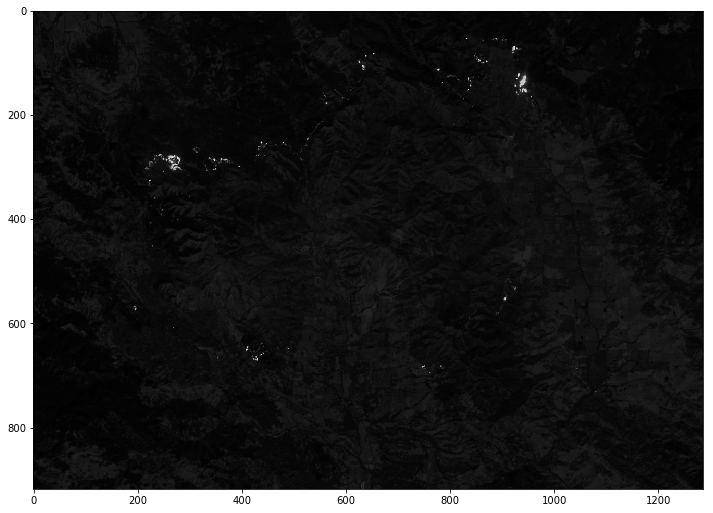

In [83]:
image = mpimg.imread('DATA/Handpicked/B12_crop.jpg')
plt.figure(figsize=(12,24))
plt.imshow(image,cmap='gray')
plt.show()

We can identify the fire sources just by using a simple threshold.

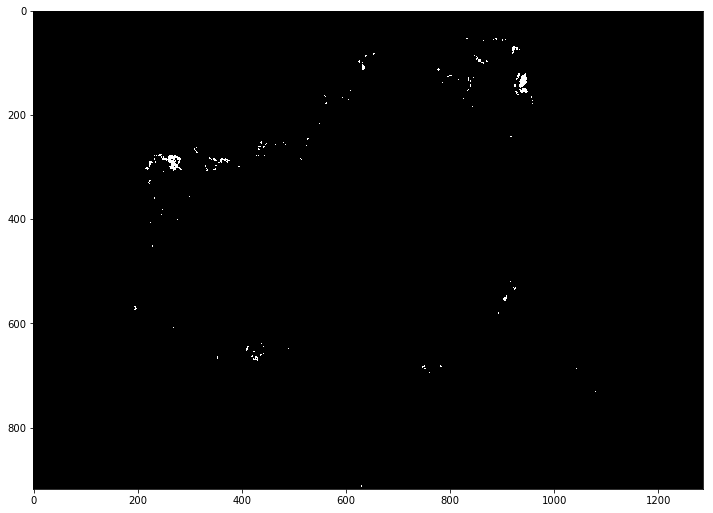

In [39]:
fire = image > 30
fire.astype(int)

plt.figure(figsize=(12,24))
plt.imshow(fire, cmap='gray')
plt.show()

Looks pretty sharp! But I'm going to stick to this tutorial that identifies multiple bright spots https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/

Let's apply a gaussian blur to the image, to "spread" the presence of a fire.

(what's this ksize argument of the GaussianBlur function? https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html

ksize – Gaussian kernel size. ksize.width and ksize.height can differ but they both must be positive and odd. Or, they can be zero’s and then they are computed from sigma*.)

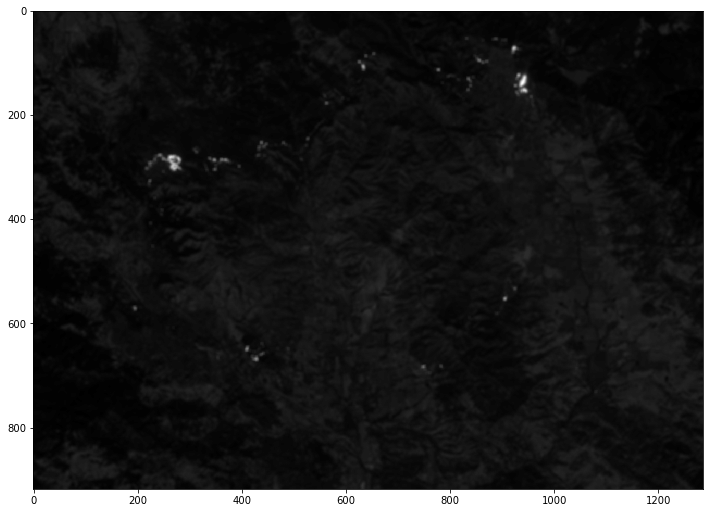

In [54]:
blurred = cv2.GaussianBlur(image, (7,7), 4)

plt.figure(figsize=(12,24))
plt.imshow(blurred,cmap='gray')
plt.show()

Let's apply the threshold now, a little lower than before, since we applied a gaussian blur to the initial image.

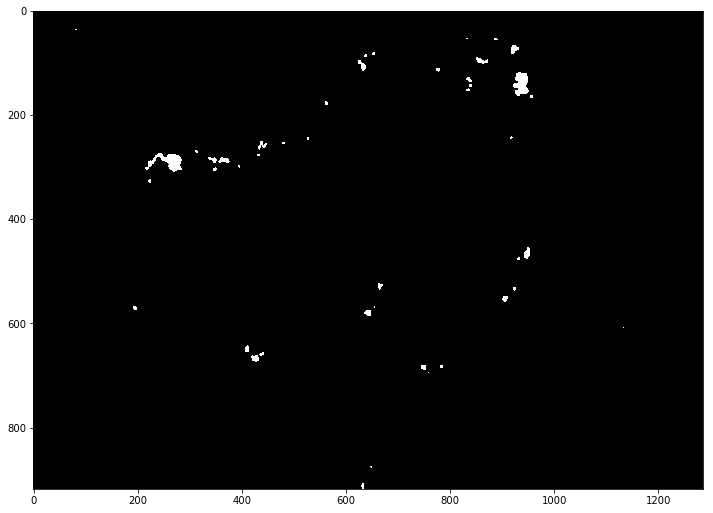

In [125]:
# threshold the image to reveal light regions in the blurred image
thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(12,24))
plt.imshow(thresh,cmap='gray')
plt.show()

It's a bit better now! We still need to remove some of the noise as well as accentuate the larger areas. We'll use a sequence of erosions and dilatations to this effect. After some experimentation, these operations yielded the best results.

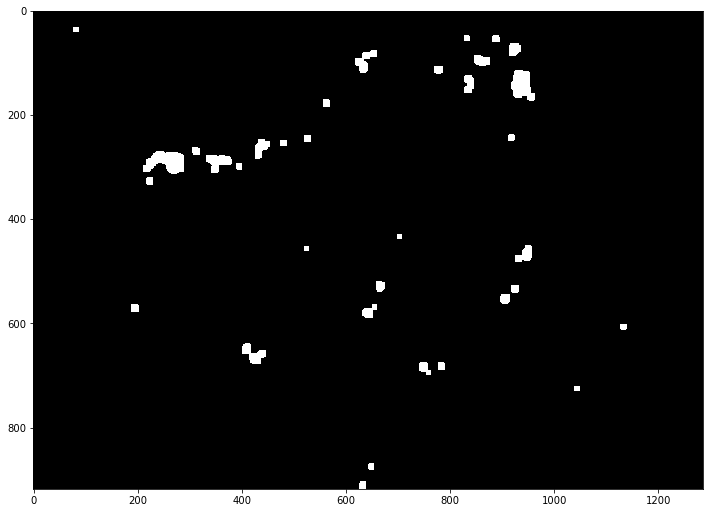

In [126]:
thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)[1]

thresh = cv2.dilate(thresh, None, iterations=5)
thresh = cv2.erode(thresh, None, iterations=4)
thresh = cv2.dilate(thresh, None, iterations=3)

plt.figure(figsize=(12,24))
plt.imshow(thresh,cmap='gray')
plt.show()

Now we will perform a connected component analysis with 8-connectivity, storing the more representative components in a mask.

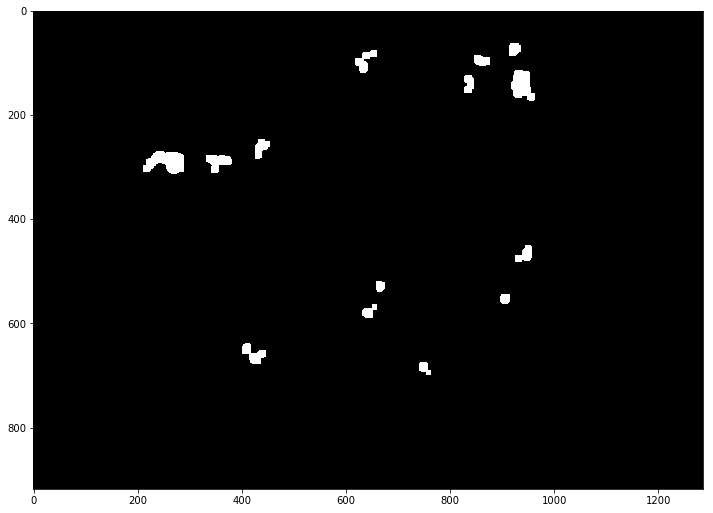

In [127]:
labels = measure.label(thresh, neighbors=8, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")

# loop over the unique components
for label in np.unique(labels):
	# if this is the background label, ignore it
	if label == 0:
		continue
 
	# otherwise, construct the label mask and count the
	# number of pixels 
	labelMask = np.zeros(thresh.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)
 
	# if the number of pixels in the component is sufficiently
	# large, then add it to our mask of "large blobs"
	if numPixels > 300:
		mask = cv2.add(mask, labelMask)
        
plt.figure(figsize=(12,24))
plt.imshow(mask,cmap='gray')
plt.show()

Now we will draw a circle on each area and label them from left to right.

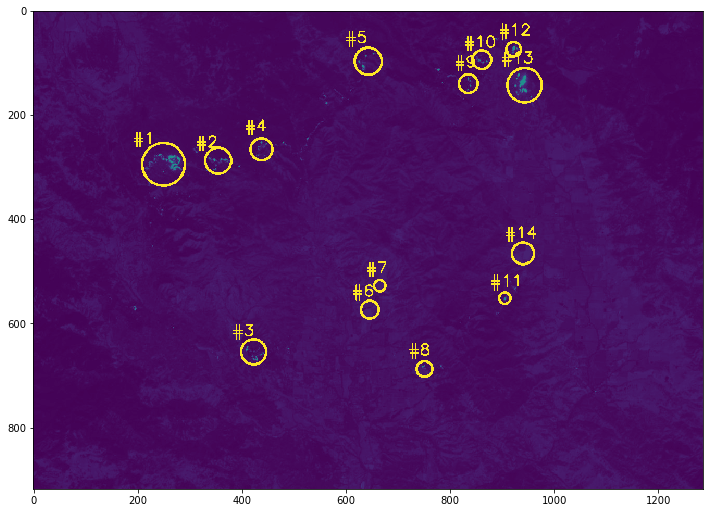

In [129]:
# reloading the image
image= mpimg.imread('DATA/Handpicked/B12_crop.jpg')

# find the contours in the mask, then sort them from left to
# right
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = contours.sort_contours(cnts)[0]
 
# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the bright spot on the image
	(x, y, w, h) = cv2.boundingRect(c)
	((cX, cY), radius) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(cX), int(cY)), int(radius),
		(255, 0, 0), 3)
	cv2.putText(image, "#{}".format(i + 1), (x-20, y - 15),
		cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
 
# show the output image
plt.figure(figsize=(12,24))
plt.imshow(image)
plt.show()

Some of the areas found have already burned, and do not have live flames at the moment. Still, the labeling seems pretty nice! Maybe we can try to look at a bigger picture and try to identify burnt regions next.